# TMDB Movie Analysis

Author: Hilton Lam (2024)

By leveraging their public API, I use datasets from TMDB, a popular movie and TV review platform, to explore key trends in the film industry. Using Python, I clean and preprocess the data before analysing patterns such as production volume and popularity by country, genre-based popularity, and the relationship between budget and popularity. Additionally, I leverage the **Gemini LLM API** to identify common themes among top-performing movies.

### Notebook 2: Data Analysis

This notebook is focused on cleaning, processing and analysing the dataset extracted from Notebook 1. 

Key trends shown in this notebook:
- Production volume and popularity by country
- Popularity distribution by genre
- Corelation between budget and popularity
- Common themes across top performing movies (using Gemini LLM)

### Import data from Notebook 1

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [4]:
# Use this step to retrieve the saved file, generated by Notebook 1
df_movie_details = pd.read_csv('movie_details_backup.csv')

### Transforming the dataframe for analysis

Preparing the dataframe with the required fields for analysis

In [6]:
# Create a dataframe with the selected columns only
movie_fields = ['id','original_title','title', 'adult','budget','genres','origin_country','original_language','overview','release_date','tagline','vote_average','vote_count']
df = df_movie_details[movie_fields] 
df.head()

,id,original_title,title,adult,budget,genres,origin_country,original_language,overview,release_date,tagline,vote_average,vote_count
0,1184918,The Wild Robot,The Wild Robot,False,78000000,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",['US'],en,"After a shipwreck, an intelligent robot called...",2024-09-12,Discover your true nature.,8.600,1444
1,912649,Venom: The Last Dance,Venom: The Last Dance,False,110000000,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",['US'],en,Eddie and Venom are on the run. Hunted by both...,2024-10-22,'Til death do they part.,6.493,75
2,933260,The Substance,The Substance,False,17500000,"[{'id': 27, 'name': 'Horror'}, {'id': 18, 'nam...",['GB'],en,A fading celebrity decides to use a black mark...,2024-09-07,"If you follow the instructions, what could go ...",7.300,867
3,1029235,Azrael,Azrael,False,12000000,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",['US'],en,"In a world where no one speaks, a devout femal...",2024-09-27,Many years after the rapture… Among the surviv...,6.111,90
4,1034541,Terrifier 3,Terrifier 3,False,2000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",['US'],en,Five years after surviving Art the Clown's Hal...,2024-10-09,"You better not shout, you better not cry.",7.200,140


In [7]:
# Understand the dataset 
pd.set_option('display.float_format', lambda x: '%.3f' % x) # disable scientific numbers
df.describe()

,id,budget,vote_average,vote_count
count,4732.000,4732.000,4732.000,4732.000
mean,1276317.148,774129.673,1.394,90.081
std,203942.250,7420232.658,2.931,1250.617
min,81.000,0.000,0.000,0.000
25%,1280686.250,0.000,0.000,0.000
50%,1358219.500,0.000,0.000,0.000
75%,1366972.250,0.000,0.000,0.000
max,1376826.000,195000000.000,10.000,35422.000


This shows that many movies (at least 75%+) have no budget indicated in the dataset and have 0 votes.

Therefore, I will **remove those movies with limited votes and data in order to create a cleaner and representative dataset for analysis.**

In [9]:
## Remove the movies that have less than 5 votes 
df_w_votes = df[(df['vote_count'] >= 5)]
df_w_votes.describe()

,id,budget,vote_average,vote_count
count,427.000,427.000,427.000,427.000
mean,871705.265,8218876.768,6.679,996.419
std,406330.368,23350609.610,0.993,4057.665
min,81.000,0.000,2.400,5.000
25%,804833.500,0.000,6.192,13.500
50%,995926.000,0.000,6.800,42.000
75%,1137206.000,3000000.000,7.300,208.500
max,1371727.000,195000000.000,9.200,35422.000


In [10]:
df_w_votes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 427 entries, 0 to 4658
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 427 non-null    int64  
 1   original_title     427 non-null    object 
 2   title              427 non-null    object 
 3   adult              427 non-null    bool   
 4   budget             427 non-null    int64  
 5   genres             427 non-null    object 
 6   origin_country     427 non-null    object 
 7   original_language  427 non-null    object 
 8   overview           422 non-null    object 
 9   release_date       427 non-null    object 
 10  tagline            230 non-null    object 
 11  vote_average       427 non-null    float64
 12  vote_count         427 non-null    int64  
dtypes: bool(1), float64(1), int64(3), object(8)
memory usage: 43.8+ KB


This indicates that only 427 movies have been rated at least 5 times, a very small subset of the total list of 4732 movies. This indiciates that **most movies have never been rated in this website**. Also, more than half of these movies do not have budget listed.

### Unpacking the arrays and joining with useful labels

The columns "origin_country" and "genre_name" are both arrays. I am unpacking them here for analysis.

In [14]:
df_unnested = df_w_votes.copy() # Create a copy of the dataset

# Convert the "origin_country" column from string to Python list & unnest the arrays
df_unnested['origin_country'] = df_unnested['origin_country'].apply(ast.literal_eval)
df_unnested = df_unnested.explode('origin_country') # Unnest the arrays

# Repeat the same steps for "genres"
df_unnested['genres'] = df_unnested['genres'].apply(ast.literal_eval)
df_unnested = df_unnested.explode('genres') # Unnest the arrays

# Unpack the dictionary "name" value in the column "genres"
df_unnested['genre_name'] = [i['name'] for i in df_unnested['genres']]

df_unnested.head()

,id,original_title,title,adult,budget,genres,origin_country,original_language,overview,release_date,tagline,vote_average,vote_count,genre_name
0,1184918,The Wild Robot,The Wild Robot,False,78000000,"{'id': 16, 'name': 'Animation'}",US,en,"After a shipwreck, an intelligent robot called...",2024-09-12,Discover your true nature.,8.600,1444,Animation
0,1184918,The Wild Robot,The Wild Robot,False,78000000,"{'id': 878, 'name': 'Science Fiction'}",US,en,"After a shipwreck, an intelligent robot called...",2024-09-12,Discover your true nature.,8.600,1444,Science Fiction
0,1184918,The Wild Robot,The Wild Robot,False,78000000,"{'id': 10751, 'name': 'Family'}",US,en,"After a shipwreck, an intelligent robot called...",2024-09-12,Discover your true nature.,8.600,1444,Family
1,912649,Venom: The Last Dance,Venom: The Last Dance,False,110000000,"{'id': 28, 'name': 'Action'}",US,en,Eddie and Venom are on the run. Hunted by both...,2024-10-22,'Til death do they part.,6.493,75,Action
1,912649,Venom: The Last Dance,Venom: The Last Dance,False,110000000,"{'id': 878, 'name': 'Science Fiction'}",US,en,Eddie and Venom are on the run. Hunted by both...,2024-10-22,'Til death do they part.,6.493,75,Science Fiction


Map country names based on the country code using an external package

In [16]:
# !pip3 install pycountry
import pycountry

country_codes = {code.alpha_2: code.name for code in pycountry.countries} # Create a dictionary mapping two-digit country codes to country names
df_unnested['origin_country_name'] = df_unnested['origin_country'].map(country_codes) # Apply the mapping to the "origin_country" column

In [17]:
# Check if any movies are mapped to no country name due to mapping gaps
# print("No. of movies with unidentified country code:",df_unnested['origin_country_name'].isnull().sum())
# df_unnested[df_unnested['origin_country_name'].isnull()]

# Two rows are identified as they are mapped to SU (Soviet Union), which we can exclude for now.

### Analysis by Country

In [18]:
# Group by 'origin_country_name' and calculate the median vote_average and budget
df_country_stats = df_unnested.groupby('origin_country_name')[['vote_average', 'budget']].median().reset_index()

# Calculate the count of unique "id" values for each country
movie_count_series = df_unnested.groupby('origin_country_name')['id'].nunique().reset_index()

# Rename the column for clarity
movie_count_series.columns = ['origin_country_name', 'movie_count']

# Merge the movie_count into df_country_stats
df_country_stats = df_country_stats.merge(movie_count_series, on='origin_country_name', how='left')

# Rename columns
df_country_stats = df_country_stats.rename(columns={'vote_average': 'median_vote_average', 'budget': 'median_budget'})

# Print the resulting DataFrame
df_country_stats.sort_values(by=['movie_count'],ascending = False).head()

,origin_country_name,median_vote_average,median_budget,movie_count
53,United States,6.700,140000.000,154
13,France,6.600,0.000,71
23,Japan,7.400,0.000,34
52,United Kingdom,6.900,0.000,29
15,Germany,6.900,0.000,22


Most countries only have one movie listed with more than 5 votes, of which many of them do not have their budget listed.

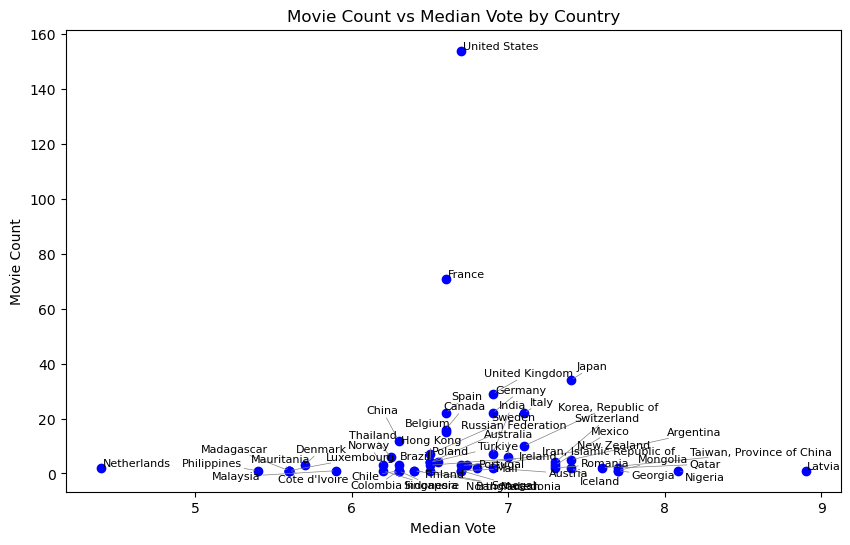

In [20]:
# !pip install adjustText
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_country_stats['median_vote_average'], df_country_stats['movie_count'], color='blue')

# Add title and axis labels
plt.title('Movie Count vs Median Vote by Country')
plt.xlabel('Median Vote')
plt.ylabel('Movie Count')

# Adding non-overlapping labels
texts = []
for i, row in df_country_stats.iterrows():
    texts.append(plt.text(row['median_vote_average'], row['movie_count'], row['origin_country_name'], fontsize=8))
adjust_text(texts, only_move={'points': 'y', 'texts': 'y'}, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.show()

A few interesting trends can be seen here:
1. The US is the powerhouse of movie production based on this dataset. They have produced a lot more movies than most other countries, but their quality does not seem to be higher than others accordingly. This may be caused by how TMDB collected data (i.e. focused on US movies).
2. The median votes for most countries concerate around 6-8, especially when they have higher movie count. This may indicate a degree of randomness. When they produce a high volume movies (or a high number of them being on TMDB), the median score is about 6-7.

I must highlight that the dataset only shows the users' opinions on TMDB, which is an English-based, American-centric platform. It represents what the voters on this platform think, rather than the reality of global movie production. Also, since the users are US-centric, they are more likely to watch and vote US movies, which may artificially inflate the number of movies produced in this analysis than the actual numbers in the world.

Also, most countries have a small sample size in this dataset (<5 movies). Hence, it will not be wise to draw any overarching conclusions on movie quality at the country level based on this data.

### Analysis by Genre

How do users rate different genres?

In [24]:
# Create a dataframe for box plot
df_genre_vote_average = df_unnested[['genre_name','vote_average']]

In [25]:
# Get the median vote for each genre
genre_median = df_genre_vote_average.groupby('genre_name')['vote_average'].median().reset_index()
df_genre_sorted = genre_median.sort_values(by='vote_average',ascending=False)

# Get the sorting order from df_genre_sorted
genre_order = df_genre_sorted['genre_name']

# Sort df "df_genre_vote_average" based on the order of "genre_order"
df_genre_vote_average['genre_name'] = pd.Categorical(
    df_genre_vote_average['genre_name'],
    categories=genre_order,
    ordered=True
)
# Sort df_genre_vote_average based on the new categorical order of genre_name
df_genre_vote_average = df_genre_vote_average.sort_values('genre_name').reset_index(drop=True)

/var/folders/n8/2y0_qtx54657nrc1941528_w0000gn/T/ipykernel_51210/4206429331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre_vote_average['genre_name'] = pd.Categorical(


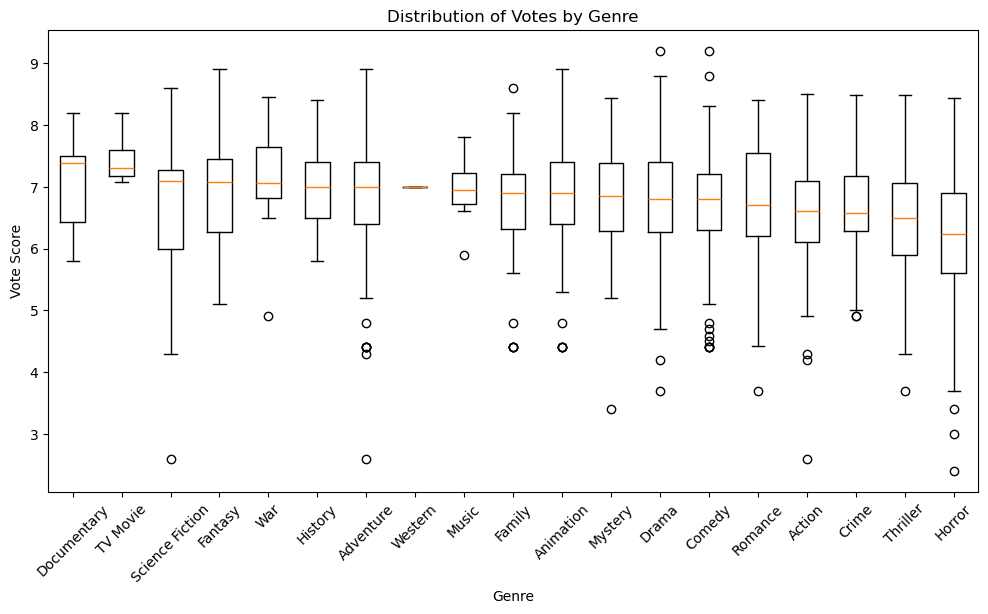

In [26]:
# Adjust the figure size to make it wider
plt.figure(figsize=(12, 6))

# Create the box plot
plt.boxplot(df_genre_vote_average['vote_average'].groupby(df_genre_vote_average['genre_name'], observed = True).apply(list))

# Set the title and labels
plt.title('Distribution of Votes by Genre')
plt.xlabel('Genre')
plt.ylabel('Vote Score')

# Rotate the x-axis labels for better readability (if needed)
plt.xticks(rotation=45)

# Set the x-ticks to match the unique genre names
plt.xticks(range(1, len(df_genre_vote_average['genre_name'].unique()) + 1), df_genre_vote_average['genre_name'].unique())

# Show the plot
plt.show()

Key takeaways:
1. The difference in median vote across genres is very small. All genres have median vote between 6.5 and 7.5.
2. However the variance of votes differs significantly by genres, i.e. some genres can be really good and really bad, whereas others can consistently good.
3. Documentary, TV Movie and War movies tend to be consistently good with a high median vote and low variance.
4. Science Fiction, Fantasy and Adventure have high median vote but also a high variance, meaning that you may sometimes get a very bad or very good movie in these genres.
5. Horror movies have the lowest median vote, high variance and a low Q1 (lower quartile) score. This means that horror movies are often bad but sometimes you get some good ones.

## Corelation Analysis

Let's now look at whether these movie characteristics have any corelations.

In [29]:
# Create a df including only movies with at least 5 votes and budget indicated
df_w_votes_budgets = df[(df['vote_count'] >= 5) & (df['budget'] > 0)] 

# Select only the numeric columns
numeric_df = df_w_votes_budgets.select_dtypes(include=['float64', 'int64'])
numeric_df.drop(columns=['id'], inplace = True)

# Compute the correlation matrix for the numeric columns
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

              budget  vote_average  vote_count
budget         1.000         0.149       0.464
vote_average   0.149         1.000       0.472
vote_count     0.464         0.472       1.000


The Pearson Coefficients above indicate there are positive corelations as follows (in descending order):
1. **Vote average and vote count (0.472)**: Average vote increases with vote count as well. This is interesting and unexpected. These could be reasons why that happened - a) users who like a movie are more likely to cast their vote on the platform, or/and b) movies that are more liked attract more votes (attention/viewership) due to words of mouth or viral effect.

2. **Budget and vote count (0.464)**: The strong relationship shows that vote count increases with budget, which may be caused by the higher awareness of the film thanks to its bigger marketing efforts. As more people know and watch the movie, they are more likely to share their opinions on the website.

3. **Budget and average vote (0.149)**: There is a weak positive relationship between budget and average vote, indicating that big budgets may not always lead to higher movie ratings.

#### Scatterplot showing relationship between budget and vote count

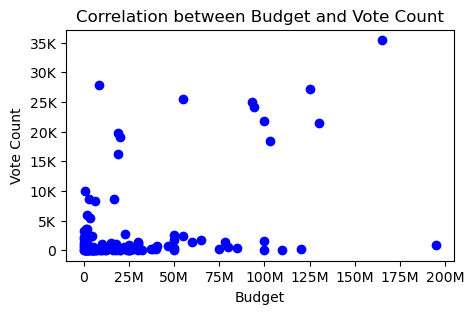

In [32]:
from matplotlib.ticker import FuncFormatter

# Scatter plot to show correlation between 'Popularity' and 'Average Vote'
plt.figure(figsize=(5, 3))  
plt.scatter(df_w_votes_budgets['budget'], df_w_votes_budgets['vote_count'], color='blue')

# Titles and labels
plt.title('Correlation between Budget and Vote Count')
plt.xlabel('Budget')
plt.ylabel('Vote Count')

# Function to format numbers with K/M 
def millions(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.0f}M'
    elif x >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{x:.0f}'

# Apply custom formatter to axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

plt.show()

## How do top movies differ from worst movies? A textual analysis using LLM.

Here I would like to collate descriptions from each movie and put it through Google's Gemini Large Language Model (LLM). In this step, we can see whether we can identify any trends from the top movies' textual information.

Information included in the text:
1. Movie title
2. Release date
3. Original language
4. Adult movie classification
5. Movie overview
6. Movie tagline

In [34]:
# Create a list of top movie id based on vote_average, limited to movies with at least 5 votes
df_top_movies = df_w_votes.sort_values(by='vote_average', ascending = False).head(20) # top 20 movies bvy average vote
df_worst_movies = df_w_votes.sort_values(by='vote_average', ascending = True).head(20) # worst 20 movies bvy average vote

In [35]:
# Create a function to concatenate the information for each movie and put them all in one paragraph
top_movies_d = ''

def movie_descriptor (df,text):
    movie_description = ''
    for i in range(len(df)):
        movie_description = movie_description + f"The ranking of this movie is {i+1} from the {text} based on user ratings. "
        movie_description = movie_description + "The title of the movie is: " + df.iloc[i]['title']
        movie_description = movie_description + ", released on " + df.iloc[i]['release_date']
        movie_description = movie_description + " and the original language is " + df.iloc[i]['original_language']
        if df.iloc[i]['adult'] == True:
            movie_description = movie_description + ". It is an adult movie. "
        else: 
            movie_description = movie_description + ". It is not an adult movie. "
        movie_description = movie_description + "Here is the overview of the movie: " + df.iloc[i]['overview']
        if pd.notna(df.iloc[i]['tagline']):
            movie_description = movie_description + " The tagline of the movie is: " + str(df.iloc[i]['tagline'])
        else:
            pass
        movie_description = movie_description + "\n"
    return movie_description

In [36]:
top_movies_d = movie_descriptor(df_top_movies,'top')
worst_movies_d = movie_descriptor(df_worst_movies,'bottom')

In [37]:
# ! pip3 install google-generativeai

import os
import google.generativeai as genai
import pathlib

# Set the environment variable for the current session
os.environ['API_KEY'] = 'insert_your_API_key_here' ## replace with your own API key
genai.configure(api_key=os.environ["API_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")

### Provide the prompt to Gemini
Ask Gemini to identify trends among the top 20 movies

In [39]:
prompt = 'Here are the details of the most liked 20 movies in TMDB, a popular online movie rating website. Can you analyse the information and tell me what is special about these 20 popular movies? What is common among them? Please do not use external information, only the text given here.'
prompt = prompt + top_movies_d

In [40]:
response = model.generate_content(prompt)
print(response.candidates[0].content.parts[0].text)

These 20 popular movies, while diverse in their genres and time periods, share some common themes:

* **Storytelling and Connection:** Many movies focus on the power of storytelling and its ability to connect people. "The Door-to-Door Bookstore" highlights the impact of books on individuals and communities. "Flow" uses a post-apocalyptic setting to explore themes of resilience and the importance of connection in a new world.  "The Wild Robot" emphasizes the role of storytelling in fostering empathy and understanding.

* **Family and Relationships:**  Several movies explore the dynamics of family and relationships. "Dying" focuses on a family reuniting in the face of death. "The Wild Robot" showcases the bonds formed between a robot and the animal world. "Grave of the Fireflies" presents a poignant portrayal of sibling love and the challenges of survival. "We Live in Time" depicts a love story spanning decades.

* **Overcoming Challenges and Resilience:**  Many stories depict characters

In [41]:
prompt = 'Here are the descriptions of the top 20 movies and the worst 20 movies, based on user ratings. Based on the information here (not externally), can you share any insights on why the top movies are better than the worst movies? '
prompt = prompt + "Description of top movies: " + top_movies_d + "\n Description of worst movies: " + worst_movies_d

In [42]:
response = model.generate_content(prompt)
print(response.candidates[0].content.parts[0].text)

Based on the provided descriptions, here are some insights into why the top-rated movies are generally considered better than the bottom-rated ones:

**Themes and Storytelling:**

* **Top movies:**  Often explore complex themes like human connection, loss, the search for meaning, redemption, and the power of stories. They feature compelling narratives with well-developed characters and thought-provoking situations.  
* **Bottom movies:** Tend towards simpler plots, relying on shock value, gore, or unoriginal premises. Characters often feel underdeveloped, and the story may lack emotional depth or a clear message.

**Genre and Execution:**

* **Top movies:** Represent a diverse range of genres (drama, fantasy, sci-fi, etc.) but are often praised for their unique and masterful execution within those genres.  
* **Bottom movies:** Seem to rely on overly familiar, formulaic tropes within their respective genres.  They might lack originality or effective storytelling techniques.

**Visuals 

It is interesting to see that **LLM can be a useful tool for analysing film characteristics beyond the structured data in the tables.** Arguably, the plot of a film is critical in determining the success of a film, and we can only understand the plot by looking at the textual description of the movies. It will be very time consuming and inefficient for humans to analyse the plots in a movie database.

While the results above are helpful and can provide a useful starting point for humans to do further analysis, **it will be better if we can provide much more information per film than the few lines of text currently offered to Gemini.** For example, we can provide more detailed plot descriptions, film transcripts and user reviews to give the LLM more context to analyse.

## Conclusion 

**Key findings**
1. The TMDB dataset is US-centric, as there are many more films from the US than from any other country. However, US films do not appear to have higher median ratings than productions from other countries.
2. The median vote is very close across genres (6.5-7.5).
3. The consistency (variance) in quality differs widely by genre, i.e. some genres such as documentaries, TV movies and war movies tend to be consistently good, while the quality in science fiction, fantasy, adventure and horror is not so consistent.
4. Highly rated films tend to get more votes.
5. High budget films tend to get more votes.
6. There is a weak positive relationship between film budget and user ratings.
7. Large Language Model (LLM) can be a helpful tool to understand why some movies perform better than others using textual information, but we should probably provide more information than a few lines of text per movie.

**Challenges**
The main challenge in this analysis is the size of the data - only a small fraction of the films (427 films out of 4732 currently playing movies) have at least 5 votes on the platform. Many of them have missing information such as budget. Therefore, when we break the data down by category, such as country, we are left with very few data points per category, making it very difficult to draw confident conclusions at the category level.

This is partly because the TMDB API has not created an easy way for developers to pull all movies on the platform that are not in one of these categories 1) now playing, 2) popular, 3) upcoming or 4) top-rated movies. Hence, it is challenging to create a larger dataset than what we currently have.

**Ideas for the future**
1. For this analysis, I have only pulled now playing films. In the future, we could consider pulling more movies on the platform (now playing or not) to create a larger, more representative dataset. We can also consider using other movie review platforms with a larger dataset.
2. To make LLM more useful, we should provide more textual information. We can consider pulling user reviews, detailed plots, or even transcripts for more comprehensive analysis.
3. It will be interesting to see how film production and user preferences have changed over time. We may be able to pull more time series data to analyse trends over time.